In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, log_loss
import seaborn as sns

train_path = '/Users/aadya.mukherjee/Documents/git my/mrm_nn2/fashion-mnist_train.csv'
test_path = '/Users/aadya.mukherjee/Documents/git my/mrm_nn2/fashion-mnist_test.csv'

# Data Preprocessing
def load_and_preprocess_data(train_path, test_path):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    if not isinstance(train_df, pd.DataFrame):
        raise ValueError("train_df is not a DataFrame. Ensure the input path points to a valid CSV file.")
    if not isinstance(test_df, pd.DataFrame):
        raise ValueError("test_df is not a DataFrame. Ensure the input path points to a valid CSV file.")

    # Extract features and labels
    y_train = train_df.iloc[:, 0].values  # First column is the label
    X_train = train_df.iloc[:, 1:].values / 255.0  # Normalize pixel values
    y_test = test_df.iloc[:, 0].values
    X_test = test_df.iloc[:, 1:].values / 255.0

    return X_train, y_train, X_test, y_test



In [36]:
# Activation Functions
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)



In [37]:
# Loss Function
def cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]
    log_likelihood = -np.log(y_pred[range(m), y_true])
    return np.sum(log_likelihood) / m

def cross_entropy_derivative(y_true, y_pred):
    m = y_true.shape[0]
    grad = y_pred
    grad[range(m), y_true] -= 1
    grad /= m
    return grad



In [38]:
# Neural Network Class
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.weights1 = np.random.randn(input_size, hidden_size) * 0.01
        self.bias1 = np.zeros((1, hidden_size))
        self.weights2 = np.random.randn(hidden_size, output_size) * 0.01
        self.bias2 = np.zeros((1, output_size))
        self.learning_rate = learning_rate
        self.loss_history = []

    def forward(self, X):
        self.Z1 = np.dot(X, self.weights1) + self.bias1
        self.A1 = relu(self.Z1)
        self.Z2 = np.dot(self.A1, self.weights2) + self.bias2
        self.A2 = softmax(self.Z2)
        return self.A2

    def backward(self, X, y_true, y_pred):
        m = X.shape[0]

        # Output layer gradients
        dZ2 = cross_entropy_derivative(y_true, y_pred)
        dW2 = np.dot(self.A1.T, dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        # Hidden layer gradients
        dA1 = np.dot(dZ2, self.weights2.T)
        dZ1 = dA1 * relu_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        # Update weights and biases
        self.weights1 -= self.learning_rate * dW1
        self.bias1 -= self.learning_rate * db1
        self.weights2 -= self.learning_rate * dW2
        self.bias2 -= self.learning_rate * db2

    def train(self, X, y, X_val, y_val, epochs=10):
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = cross_entropy_loss(y, y_pred)
            self.loss_history.append(loss)
            self.backward(X, y, y_pred)
            val_loss = cross_entropy_loss(y_val, self.forward(X_val))
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}")

    def predict(self, X):
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1)



In [39]:
# Visualization Functions
def plot_training_loss(loss_history):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def plot_misclassified(X, y_true, y_pred, labels):
    misclassified_indices = np.where(y_true != y_pred)[0]
    plt.figure(figsize=(10, 10))
    for i, index in enumerate(misclassified_indices[:16]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(X[index].reshape(28, 28), cmap='gray')
        plt.title(f"True: {labels[y_true[index]]}\nPred: {labels[y_pred[index]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()



In [40]:
# Load and preprocess data
X_train, y_train, X_test, y_test = load_and_preprocess_data(train_path, test_path)

# Split train into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)



In [51]:
# Define and train the neural network
input_size = 784  # 28x28 pixels
hidden_size = 256
output_size = 10  # 10 classes
learning_rate = 0.1

nn = NeuralNetwork(input_size, hidden_size, output_size, learning_rate)
nn.train(X_train, y_train, X_val, y_val, epochs=50)



Epoch 1/50, Loss: 2.3047, Validation Loss: 2.2971
Epoch 2/50, Loss: 2.2974, Validation Loss: 2.2900
Epoch 3/50, Loss: 2.2903, Validation Loss: 2.2829
Epoch 4/50, Loss: 2.2831, Validation Loss: 2.2754
Epoch 5/50, Loss: 2.2757, Validation Loss: 2.2673
Epoch 6/50, Loss: 2.2676, Validation Loss: 2.2585
Epoch 7/50, Loss: 2.2589, Validation Loss: 2.2487
Epoch 8/50, Loss: 2.2491, Validation Loss: 2.2378
Epoch 9/50, Loss: 2.2383, Validation Loss: 2.2256
Epoch 10/50, Loss: 2.2261, Validation Loss: 2.2119
Epoch 11/50, Loss: 2.2125, Validation Loss: 2.1967
Epoch 12/50, Loss: 2.1974, Validation Loss: 2.1799
Epoch 13/50, Loss: 2.1806, Validation Loss: 2.1613
Epoch 14/50, Loss: 2.1620, Validation Loss: 2.1409
Epoch 15/50, Loss: 2.1417, Validation Loss: 2.1186
Epoch 16/50, Loss: 2.1195, Validation Loss: 2.0946
Epoch 17/50, Loss: 2.0955, Validation Loss: 2.0686
Epoch 18/50, Loss: 2.0696, Validation Loss: 2.0409
Epoch 19/50, Loss: 2.0420, Validation Loss: 2.0115
Epoch 20/50, Loss: 2.0126, Validation Lo

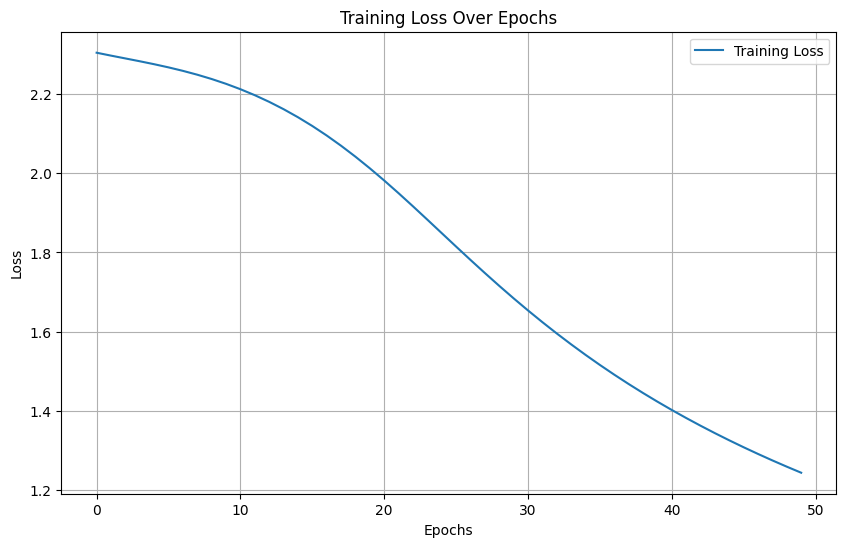

In [52]:
# Plot training loss
plot_training_loss(nn.loss_history)



In [53]:
# Evaluate the model
predictions = nn.predict(X_test)
accuracy = np.mean(predictions == y_test) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 61.68%


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.80      0.70      1000
           1       0.73      0.93      0.82      1000
           2       0.50      0.64      0.56      1000
           3       0.66      0.54      0.59      1000
           4       0.45      0.58      0.51      1000
           5       1.00      0.00      0.00      1000
           6       0.35      0.02      0.03      1000
           7       0.59      0.85      0.70      1000
           8       0.88      0.89      0.88      1000
           9       0.60      0.93      0.73      1000

    accuracy                           0.62     10000
   macro avg       0.64      0.62      0.55     10000
weighted avg       0.64      0.62      0.55     10000

Log Loss: 1.2294805254434973


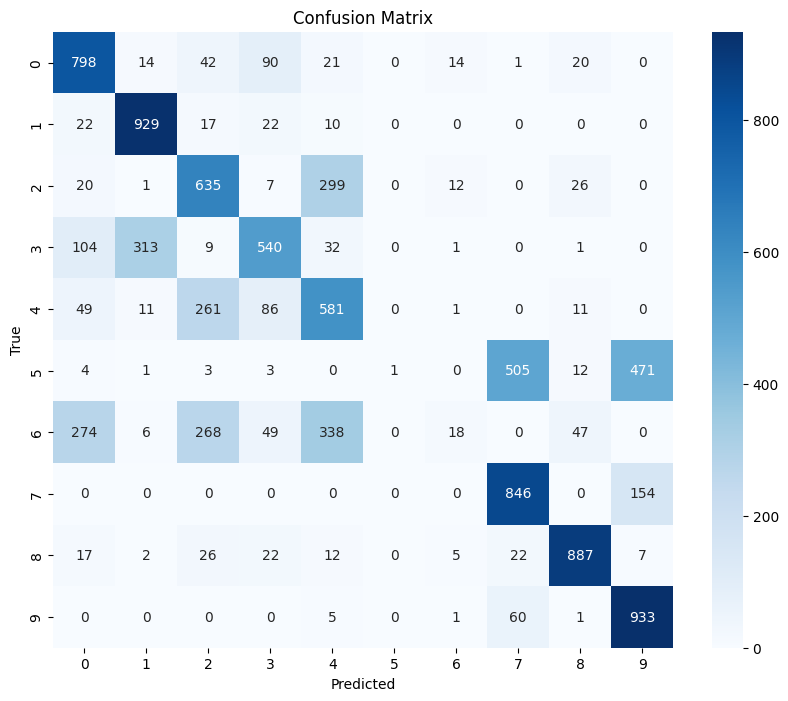

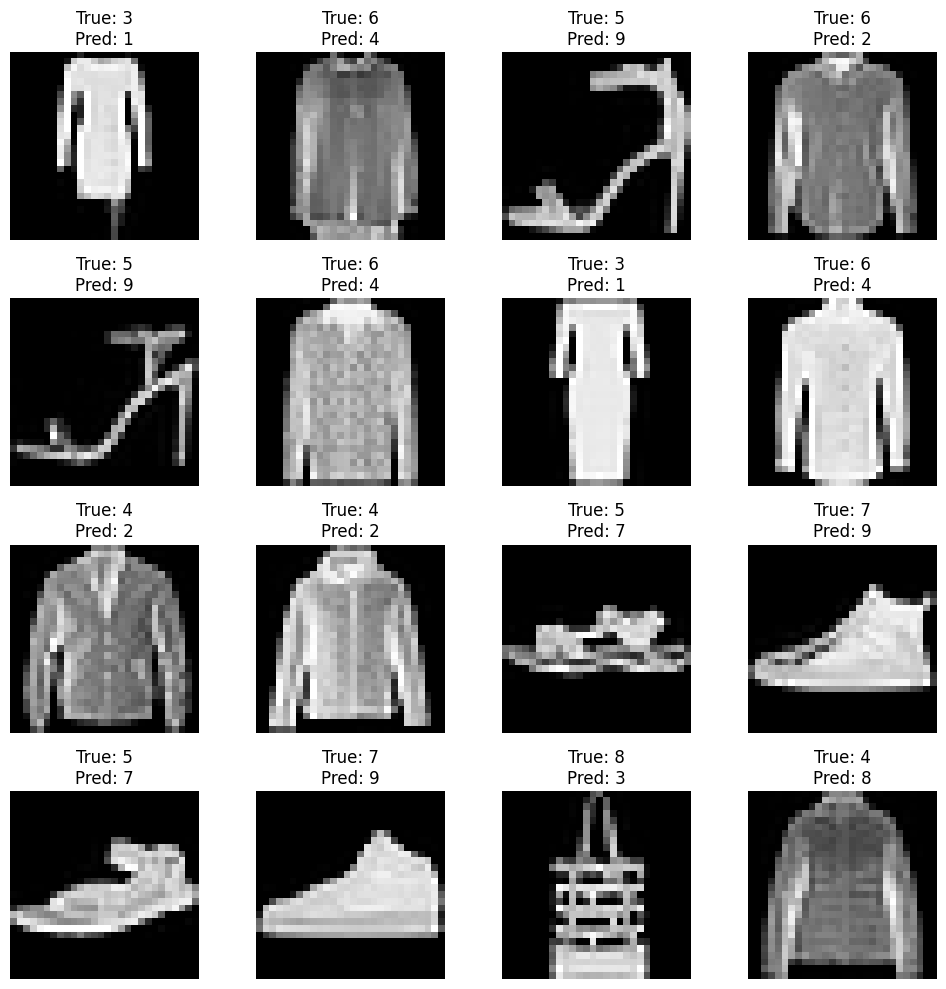

In [54]:
# Compute evaluation metrics
print("Classification Report:")
labels = [str(i) for i in range(10)]
print(classification_report(y_test, predictions, target_names=labels))

print("Log Loss:", log_loss(y_test, nn.forward(X_test)))

# Plot confusion matrix
plot_confusion_matrix(y_test, predictions, labels)

# Plot misclassified examples
plot_misclassified(X_test, y_test, predictions, labels)
